### Obteniendo los tripulantes de la ISS

* Para instalar `mpl_toolkits.basemap` y `pytrends`:
```
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pytrends
```


In [16]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image
from mpl_toolkits.basemap import Basemap
import requests
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/Colab Notebooks'

astros = requests.get(url = 'http://api.open-notify.org/astros.json').json()
print(astros)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
{'number': 3, 'message': 'success', 'people': [{'craft': 'ISS', 'name': 'Chris Cassidy'}, {'craft': 'ISS', 'name': 'Anatoly Ivanishin'}, {'craft': 'ISS', 'name': 'Ivan Vagner'}]}


### Obteniendo la posición de la ISS

In [17]:
iss_now = requests.get(url = 'http://api.open-notify.org/iss-now.json').json()
print(iss_now)

{'iss_position': {'longitude': '18.4321', 'latitude': '26.0540'}, 'message': 'success', 'timestamp': 1590247819}


In [0]:
lon = float(iss_now['iss_position']['longitude'])
lat = float(iss_now['iss_position']['latitude'])

### Graficando la posición de la ISS

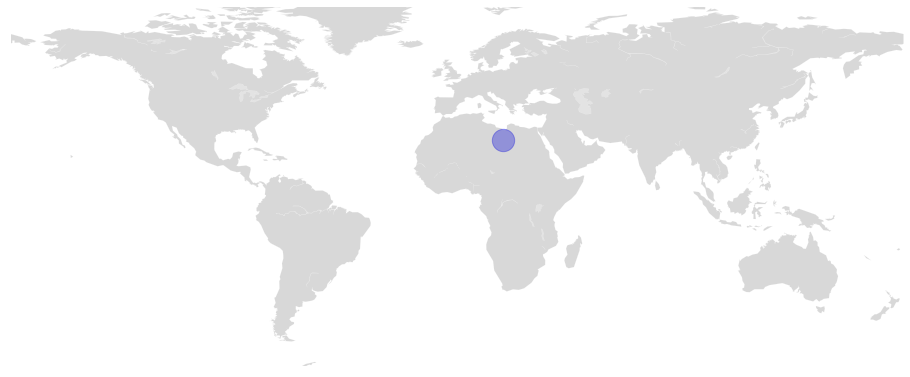

In [19]:
plt.figure(figsize=(16,8))

m = Basemap(llcrnrlon=-180,llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='white', linewidth=0)
m.fillcontinents(color='gray', alpha=0.3)
m.drawcoastlines(linewidth=0.1,color='white')

m.scatter(lon,lat,s=500,alpha=0.4,color='blue')

### Almacenando los datos

In [20]:
import datetime

date_to_print = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
print(date_to_print)

20200523153020


In [0]:
import time

start_time = time.time()

iss_data = []

recolectar = False

while len(iss_data) < 5000 and recolectar:
   iss_now = requests.get(url = 'http://api.open-notify.org/iss-now.json').json()
   print(iss_now)
   lat = iss_now['iss_position']['latitude']
   lon = iss_now['iss_position']['longitude']
   times = iss_now['timestamp']

   iss_data.append([times,lat,lon])

   tmp_iss_date = pd.DataFrame(
       iss_data, columns=['timestamp','latitude','longitude']
   )

   tmp_iss_date.to_csv(root_path+'/ISS_location_'+date_to_print+'.csv', index=None)

   time.sleep(60 - ((time.time()-start_time) % 60))

### Ver el recorrido de la ISS

In [22]:
iss_flight_track = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ISS_location_20200522133557.csv')
# print(iss_flight_track.head())
# iss_flight_track.shape

from datetime import datetime

date_time = [datetime.fromtimestamp(dt) for dt in iss_flight_track['timestamp']] # Comprenhesion para obtener el formato de tiempo de cada valor del .csv
iss_flight_track['date'] = date_time # Agrega la columna date para poder trabajar con el tiempo transformado correctamente.

iss_flight_track['index'] = range(1,len(iss_flight_track)+1) # Agrega un índice en orden descendiente
iss_flight_track.head()

,timestamp,latitude,longitude,date,index
0,1590165931,27.2724,138.3768,2020-05-22 16:45:31,1
1,1590165991,24.4580,141.1055,2020-05-22 16:46:31,2
2,1590166052,21.5883,143.7019,2020-05-22 16:47:32,3
3,1590166111,18.6965,146.1662,2020-05-22 16:48:31,4
4,1590166171,15.7424,148.5580,2020-05-22 16:49:31,5


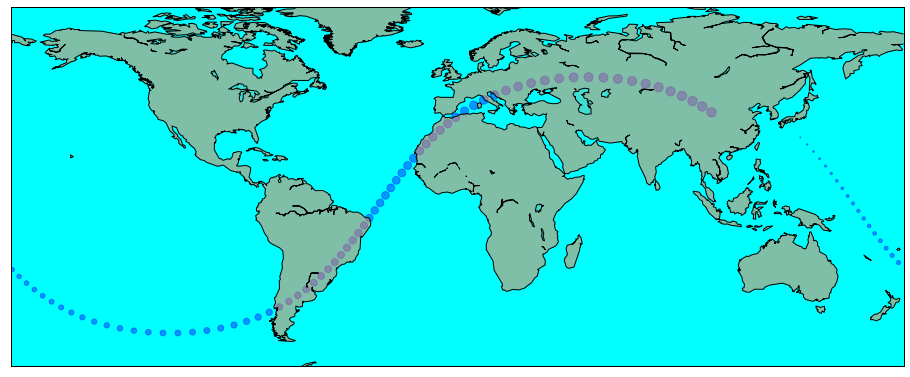

In [23]:
plt.figure(figsize=(16,8))

m = Basemap(llcrnrlon=-180,llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral',lake_color='aqua', alpha=0.5)
m.drawcoastlines()

m.scatter(iss_flight_track['longitude'],iss_flight_track['latitude'],s=iss_flight_track['index'],alpha=0.4,color='blue')

### Analizando los datos para predecir la posición mediante regresión lineal

In [24]:
tmp_iss_data = iss_flight_track.tail(10)
tmp_iss_data

,timestamp,latitude,longitude,date,index
80,1590170731,51.4197,58.9973,2020-05-22 18:05:31,81
81,1590170791,50.8992,64.8434,2020-05-22 18:06:31,82
82,1590170851,50.0610,70.5623,2020-05-22 18:07:31,83
83,1590170911,48.9279,76.0412,2020-05-22 18:08:31,84
84,1590170972,47.5243,81.2358,2020-05-22 18:09:32,85
85,1590171031,45.8916,86.0830,2020-05-22 18:10:31,86
86,1590171091,44.0292,90.6573,2020-05-22 18:11:31,87
87,1590171151,41.9762,94.9230,2020-05-22 18:12:31,88
88,1590171211,39.7765,98.8634,2020-05-22 18:13:31,89
89,1590171271,37.4154,102.5656,2020-05-22 18:14:31,90


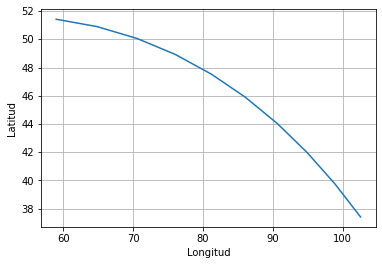

In [25]:
plt.plot(tmp_iss_data['longitude'],tmp_iss_data['latitude'])
plt.ylabel('Latitud')
plt.xlabel('Longitud')
plt.grid()

In [26]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress( # Regresión lineal usando el módulo scipy
    x = tmp_iss_data['longitude'],
    y = tmp_iss_data['latitude']
)

print('Intercept: %s' % intercept)
print('Slope: %s' % slope)

Intercept: 72.12125616680368
Slope: -0.3192293941831421


La regresión lineal es un método estadístico utilizado para aproximar la relación de dependencia entre $Y$ y $X$.

La fórmula principal es la ecuación de la recta ($y=ax+b$) dónde $y$ es la variable que se quiere predecir.

Para calcularla, la forma fácil es usar las fórmulas base:

* $x=\frac{y-a}{b}$

* $b=\frac{(cantidad*xy)-(x*y)}{(cantidad*xx)-(x*x)}$

* $a=\frac{y-(b*x)}{cantidad}$

In [27]:
predict_lat = np.ceil(intercept + slope * 105) # Predecir la latitud cuando la logintud es de 59
print('La latitud es: %s' % predict_lat)

La latitud es: 39.0


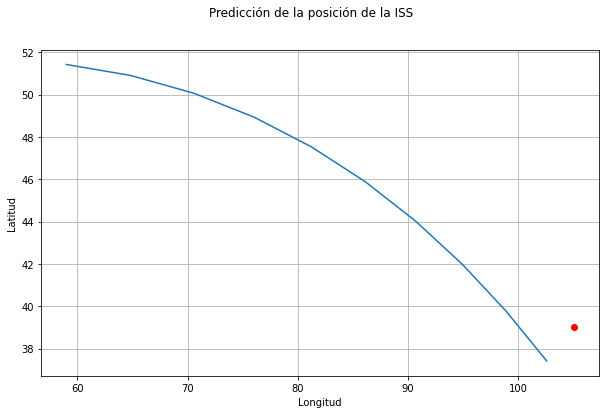

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(tmp_iss_data['longitude'], tmp_iss_data['latitude'])
plt.suptitle('Predicción de la posición de la ISS')
plt.ylabel('Latitud')
plt.xlabel('Longitud')
plt.grid()

plt.scatter(105, predict_lat, color='red') # 105 es el valor del punto en el eje y

La gráfica de la latitud y longitud de la ISS indica que no es una línea, es una curva, por lo tanto la **regresión lineal** no predice bien el resultado.

### Predicción mediante regresión polinomial

La [regresión polinomial](https://conzmr.wordpress.com/2017/04/04/regresion-polinomial/) es una forma de regresión lineal en la que la relación entre la variable independiente x y la variable dependiente y es modelada como un polinomio de grado $n$ en $x$. ($m$ es la cantidad de la muestra)

${\displaystyle \mathbb {S} =\;{\begin{Bmatrix}am&b\sum x&c\sum x^{2}&d\sum x^{3}&\cdots \ &=&\sum y\\a\sum x&b\sum x^{2}&c\sum x^{3}&d\sum x^{4}&\cdots \ &=&\sum xy\\a\sum x^{2}&b\sum x^{3}&c\sum x^{4}&d\sum x^{5}&\cdots \ &=&\sum x^{2}y\\a\sum x^{3}&b\sum x^{4}&c\sum x^{5}&d\sum x^{6}&\cdots \ &=&\sum x^{3}y\\\vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots \\\end{Bmatrix}}}$

En este caso agregará más precisión al modelo ya que este presenta un comportamiento curvo y no lineal.

La latitud es:  35.74311170449414


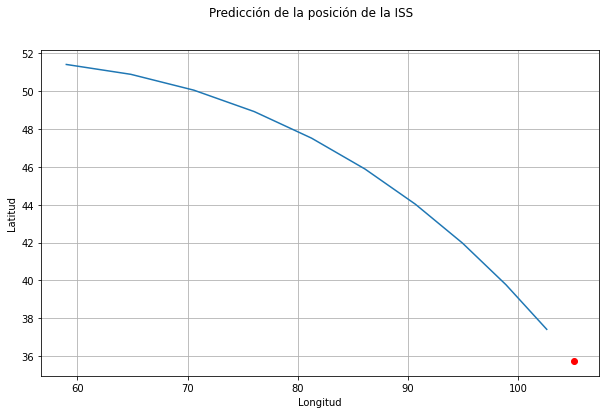

In [29]:
x = tmp_iss_data['longitude']
y = tmp_iss_data['latitude']

poli_regrec = np.poly1d(np.polyfit(x, y, 3)) # El tercer parámetro de polyfit es el grado del polinomio

predict_lat = poli_regrec(105) # Predecir la latitud dada una longitud de 98

print('La latitud es: ',predict_lat)

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(tmp_iss_data['longitude'], tmp_iss_data['latitude'])
plt.suptitle('Predicción de la posición de la ISS')
plt.ylabel('Latitud')
plt.xlabel('Longitud')
plt.grid()

plt.scatter(105, predict_lat, color='red') # 98 corresponde al valor del punto en el eje y

### Conclusiones

El modelo predice bien cuando es acotado, ya que produce una curva que es fácilmente deducible mediante la regresión polinomial, pero a mayor cantidad de puntos tomados como referencia, se exhibe un comportamiento cíclico (algún tipo de función senoidal u otra), por lo tanto habría que utilizar otro modelo basado en ese comportamiento para precedir correctamente el trayecto cuanto mayor sean los datos.